In [25]:
import os
import numpy as np
from sklearn.utils import shuffle
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
import networkx as nx




from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from spektral.layers import GATConv
from spektral.data import Dataset
from spektral.data.graph import Graph
import os
import random as rand
from random import randint
from numpy.random import rand,randint
import numpy as np
from spektral.transforms import LayerPreprocess
from sklearn.model_selection import train_test_split
import pandas as pd
from spektral.data.loaders import SingleLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [2]:
data_dir='/Users/abishek/Desktop/Abishek/graph_ml/data/'

In [3]:
#loading the data

all_data = []
all_edges = []

for root,dirs,files in os.walk(data_dir+'cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

                
#Shuffle the data because the raw data is ordered based on the label
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

In [4]:
#parse the data
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #the number of nodes
F = X.shape[1] #the size of node features
print('X shape: ', X.shape)


#parse the edge
edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Genetic_Algorithms', 'Theory', 'Probabilistic_Methods', 'Reinforcement_Learning', 'Neural_Networks', 'Case_Based', 'Rule_Learning'}

Number of classes:  7


In [5]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [6]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
# print('Graph info: ', nx.info(G))

In [7]:
class CustomCoraDataset(Dataset):
    def __init__(self, nodes, feats,labels,**kwargs):
        self.nodes = nodes
        self.feats = feats
        self.labels=labels
        super().__init__(**kwargs)

    def read(self):
        # We must return a list of Graph objects
        output = []
        output.append(Graph(x=self.nodes, a=self.feats, y=self.labels))


        return output

In [8]:
dataset=CustomCoraDataset(X,A,labels_encoded)

In [10]:
## To create dataset with transformation d(-1/2)*A(hat)+I*d(-1/2)
dataset=CustomCoraDataset(X,A,labels_encoded,transforms=[LayerPreprocess(GATConv)])

In [14]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping
n_attn_heads = 8 ## number of attention heads in first GAT layer (This is K, We will have 8 different weight mattrices for each attention head)

In [15]:
N = dataset.n_nodes  # Number of nodes in the graph
F = dataset.n_node_features  # Original size of node features
n_out = dataset.n_labels  # Number of classes

# Model definition
x_in = Input(shape=(F,))
a_in = Input((N,), sparse=True)

do_1 = Dropout(dropout)(x_in)
gc_1 = GATConv(
    channels,
    attn_heads=n_attn_heads,
    concat_heads=True,
    dropout_rate=dropout,
    activation="elu",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_1, a_in])
do_2 = Dropout(dropout)(gc_1)
gc_2 = GATConv(
    n_out,
    attn_heads=1,
    concat_heads=False,
    dropout_rate=dropout,
    activation="softmax",
    kernel_regularizer=l2(l2_reg),
    attn_kernel_regularizer=l2(l2_reg),
    bias_regularizer=l2(l2_reg),
)([do_2, a_in])

2023-06-03 16:07:33.281099: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Build model
model = Model(inputs=[x_in, a_in], outputs=gc_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GAT = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GAT_cora',
)
callback_GCN = [tbCallBack_GAT]

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 1433)         0           input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
gat_conv (GATConv)              (None, 128)          183808      dropout_1[0][0]                  
                                                                 input_6[0][0]              

/Users/abishek/Desktop/Projects/virtual_envs/graph_ml/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
2023-06-03 16:08:58.631692: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-06-03 16:08:58.631713: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-06-03 16:08:58.632955: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.


In [20]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 20 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx


train_idx,val_idx,test_idx = limit_data(labels)

In [21]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [22]:
loader_train = SingleLoader(dataset, sample_weights=train_mask)
loader_val = SingleLoader(dataset, sample_weights=val_mask)

In [23]:
model.fit(
    loader_train.load(),
    steps_per_epoch=loader_train.steps_per_epoch,
    validation_data=loader_val.load(),
    validation_steps=loader_val.steps_per_epoch,
    epochs=epochs,
    callbacks=[EarlyStopping(patience=es_patience, restore_best_weights=True)],
)

Epoch 1/200


2023-06-03 16:09:49.727749: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1/1 [==============================] - 2s 2s/step - loss: 0.1097 - acc: 0.1500 - val_loss: 0.3547 - val_acc: 0.7160
Epoch 2/200
1/1 [==============================] - 0s 98ms/step - loss: 0.1030 - acc: 0.7571 - val_loss: 0.3423 - val_acc: 0.7740
Epoch 3/200
1/1 [==============================] - 0s 96ms/step - loss: 0.0983 - acc: 0.8643 - val_loss: 0.3289 - val_acc: 0.7760
Epoch 4/200
1/1 [==============================] - 0s 96ms/step - loss: 0.0968 - acc: 0.8714 - val_loss: 0.3150 - val_acc: 0.7760
Epoch 5/200
1/1 [==============================] - 0s 93ms/step - loss: 0.0940 - acc: 0.8571 - val_loss: 0.2994 - val_acc: 0.7760
Epoch 6/200
1/1 [==============================] - 0s 93ms/step - loss: 0.0904 - acc: 0.8714 - val_loss: 0.2843 - val_acc: 0.7740
Epoch 7/200
1/1 [==============================] - 0s 97ms/step - loss: 0.0836 - acc: 0.8571 - val_loss: 0.2702 - val_acc: 0.7720
Epoch 8/200
1/1 [==============================] - 0s 91ms/step - loss: 0.0809 - acc: 0.8500 - val_loss:

In [24]:
# Evaluate model
print("Testing model.")
loader_te = SingleLoader(dataset, sample_weights=test_mask)
eval_results = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done.\n" "Test loss: {}\n" "Test accuracy: {}".format(*eval_results))

Testing model.
1/1 [==============================] - 0s 45ms/step - loss: 0.3135 - acc: 0.8180
Done.
Test loss: 0.3135489821434021
Test accuracy: 0.8180000185966492


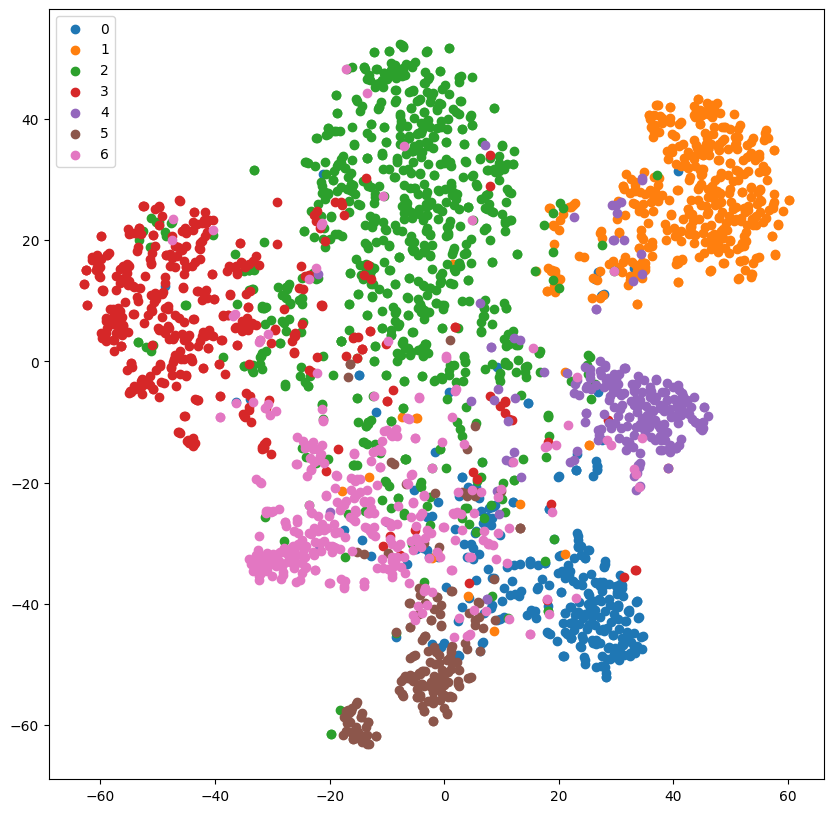

In [26]:
#Get the hidden layer representation after the first GCN layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
x_tsne = TSNE(n_components=2).fit_transform(activations[3]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

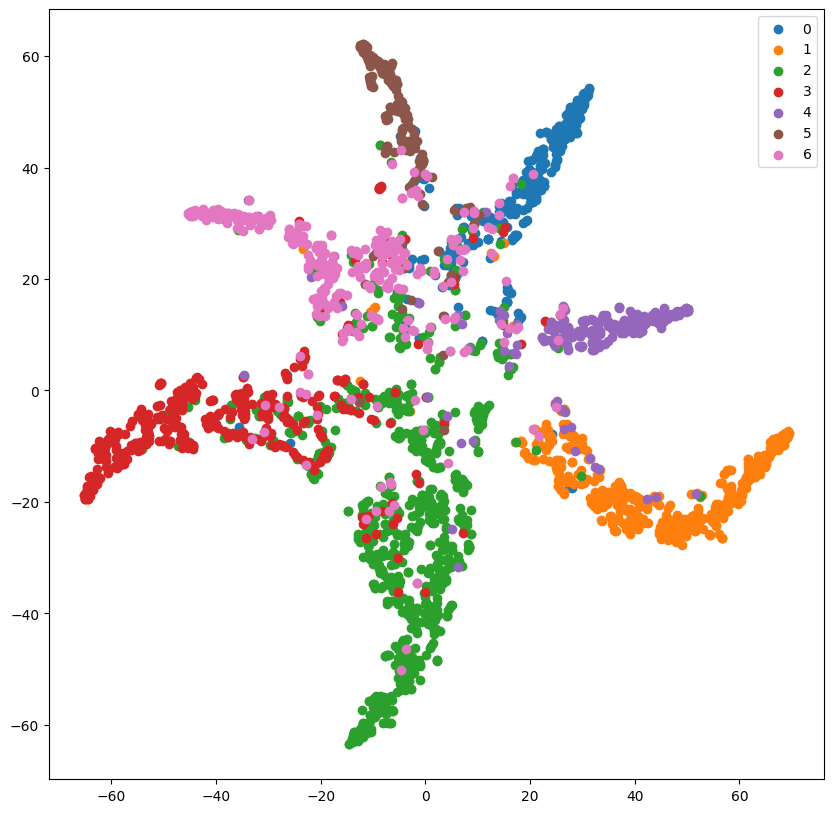

In [27]:
#Get the hidden layer representation after the second GCN layer
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
x_tsne = TSNE(n_components=2).fit_transform(activations[-1]) 

def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)